In [1]:
# Idea inspired by https://arxiv.org/abs/1806.07366 (?)


Given our problem:

$$
\frac{\partial \rho}{\partial t} = \sigma^2 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(v_m(1-2\rho) \right)
$$

$$
\sigma^2 \frac{\partial \rho}{\partial x_1} - \rho v_m(1-\rho) = -a (\rho_{max} - \rho) \quad x = 0 
$$

$$
-\sigma^2 \frac{\partial \rho}{\partial x_1} + \rho v_m(1-\rho)= b \rho \quad x = L
$$

At steady-state:

$$
\frac{\partial \rho}{\partial t} = 0
$$

And so
$$
\sigma^2 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(v_m(1-2\rho) \right) = 0
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [3]:
model_key = jax.random.PRNGKey(1)

input_dim = 'scalar'
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [4]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [5]:
def cosine_spacing(start, end, steps):
    linspace = jnp.linspace(0, jnp.pi, steps)
    cosine_values = (1 - jnp.cos(linspace))/2  # This maps the values to [0, 1]
    return start + (end - start) * cosine_values

In [6]:
loss(model, sigma2, L, a, b)

NameError: name 'loss' is not defined

In [ ]:
def custom_activation(y):
    # Ensure the input is within the valid range to avoid domain errors
    y = jnp.clip(y, -0.99, 0.99)
    return 0.5 * jnp.log((1 + y) / (1+jnp.abs(1 - y)))

In [ ]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.gelu(layer(x))
        
        x = self.layers[-1](x)
        return x

In [225]:
class ResNet(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.

    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the ResNet

        Args:
            key (jax key): Random Key
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (int): Number of hidden layers
            output_dim (int): Output layer dimension
        """
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    def __call__(self, x):
        """Forward-pass the input through the network with residual connections

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for i, layer in enumerate(self.layers[:-1]):
            if i % 2 == 0 and i != 0:
                x = x + prev_x  # Add the previous input for residual connection
            prev_x = x
            x = jax.nn.sigmoid(layer(x))
        
        x = self.layers[-1](x)
        return x

In [158]:
x = jnp.array([-1,2,-3,4,-5])

In [159]:
x

Array([-1,  2, -3,  4, -5], dtype=int32)

In [160]:
key = jax.random.PRNGKey(7)
layer = eqx.nn.Linear(5,5, key=key)

In [161]:
layer(x)

Array([-0.5671904 ,  0.45889285, -3.0662282 ,  0.16514823, -4.855752  ],      dtype=float32)

In [175]:
rbf = RBFLayer(5,5,3, key)

In [176]:
rbf(x).squeeze()

Array([  6.3791738 ,   0.09164511, -10.197619  ,  -5.636475  ,
         3.1227841 ], dtype=float32)

In [177]:
# Define the RBF Layer
class RBFLayer(eqx.Module):
    centers: jnp.ndarray
    betas: jnp.ndarray
    weights: jnp.ndarray
    
    def __init__(self, input_dim, output_dim, num_centers, key):
        super().__init__()
        self.centers = jax.random.normal(key, (num_centers, input_dim))*0
        self.betas = jax.random.normal(key, (num_centers,))*0.1
        self.weights = jax.random.normal(key, (num_centers, output_dim))*0.1
    
    def __call__(self, x):
        # Compute the distance between the input and the centers
        dists = jnp.linalg.norm(x - self.centers[None, :, :], axis=2)
        
        # Apply the RBF (Gaussian function)
        rbf_outputs = jnp.exp(-self.betas * (dists ** 2))
        
        # Compute the weighted sum of the RBF outputs
        return (rbf_outputs @ self.weights).squeeze()

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [RBFLayer(dims[i], dims[i + 1], dims[i], key=keys[i]) if i == 3 else eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.gelu(layer(x))
        
        x = self.layers[-1](x)
        return x

In [178]:
sigma2 = 0.1**2

L = 3.0


a = 0.9
b = 0.975

v_max = 1.5
p_max = 1 # rho_max cannot be learned Susana's paper

In [179]:
def loss(model, sigma2, L, a, b, steps=50):

    x_flat = cosine_spacing(0, L, steps)
    
    inputs = jnp.concat([x_flat, jnp.array([0.0]), jnp.array([L])])
    

    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad
    d2p_dx2 = hess

    # PDE Loss
    pde_loss = sigma2*d2p_dx2 - dp_dx*(v_max*(1-2*rho))

    # in loss
    in_loss = sigma2*dp_dx[-2] - rho[-2]*v_max*(1-rho[-2]) + a*(1-rho[-2])

    # out loss
    out_loss = -sigma2*dp_dx[-1] + rho[-1]*v_max*(1-rho[-1]) - b*rho[-1]

    return jnp.average(pde_loss**2) + in_loss**2 + out_loss**2


In [180]:
def loss(model, sigma2, L, a, b, subkey, steps=50):

    x_flat = cosine_spacing(0, L, steps)

    ### IMPORTANT: Point in the dissertation that having a random samples greatly improve the learning
    ### Even more, for a Sigma=0.5, a=0.9, b=0.975 and v_max = 1.5, for a NN 10x10
    ### the deterministic learning simple got stuck and didn't progress. While the sampling case
    ### converged quickly
    x_flat = jax.random.choice(subkey, x_flat, shape=(int(steps/2),), replace=False)
    
    inputs = jnp.concat([x_flat, jnp.array([0.0]), jnp.array([L])])
    
    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad
    d2p_dx2 = hess

    # PDE Loss
    pde_loss = sigma2*d2p_dx2 - dp_dx*(v_max*(1-2*rho))

    # in loss
    in_loss = sigma2*dp_dx[-2] - rho[-2]*v_max*(1-rho[-2]) + a*(1-rho[-2])

    # out loss
    out_loss = -sigma2*dp_dx[-1] + rho[-1]*v_max*(1-rho[-1]) - b*rho[-1]

    return jnp.average(pde_loss**2) + in_loss**2 + out_loss**2


In [181]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, L, sigma2, a, b, subkey, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, sigma2, L, a, b, subkey, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [182]:
# Erros < 1e-9
# Adam: 20.3
# Adabelief: 18.6
# adamax: 21
# noisy_sgd: 4.3
# optimistic_gradient_descent: 6.6
# SGD: 5.9


In [194]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(7)

input_dim = 'scalar'
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=7, n_layers=7, output_dim=output_dim)

In [190]:
model(4)

Array(-0.00177903, dtype=float32)

In [191]:
# Optimizer definition
lr = 10e-3
optimizer = optax.noisy_sgd(learning_rate=lr)
opt_state = optimizer.init(model)
opt = 'sgd'

In [192]:
# Training loop
num_epochs = 250000
losses = []

sigma2 = 0.1**2
loss_value = 100

train_key = jax.random.PRNGKey(75)

#for epoch in range(num_epochs):
epoch = 0
while loss_value > 5e-8:

    train_key, subkey = jax.random.split(train_key)
    
    model, opt_state, loss_value = train_step(model, opt_state, L, sigma2, a, b, subkey, steps=200)
    epoch += 1 

    if epoch % 100 == 0:
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")

        
    if epoch % 10000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate



# Print final loss
final_loss = loss(model, L, sigma2, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 100, Loss: 0.017521236091852188
Epoch 200, Loss: 0.017516296356916428
Epoch 300, Loss: 0.017517223954200745
Epoch 400, Loss: 0.017513392493128777
Epoch 500, Loss: 0.017514334991574287
Epoch 600, Loss: 0.017514245584607124
Epoch 700, Loss: 0.017515746876597404
Epoch 800, Loss: 0.017514443024992943
Epoch 900, Loss: 0.01751377433538437
Epoch 1000, Loss: 0.017514057457447052
Epoch 1100, Loss: 0.01751386746764183
Epoch 1200, Loss: 0.017514744773507118
Epoch 1300, Loss: 0.017513835802674294
Epoch 1400, Loss: 0.017514748498797417
Epoch 1500, Loss: 0.017513763159513474
Epoch 1600, Loss: 0.017513880506157875
Epoch 1700, Loss: 0.017513731494545937
Epoch 1800, Loss: 0.017514100298285484
Epoch 1900, Loss: 0.017514079809188843
Epoch 2000, Loss: 0.017514163628220558
Epoch 2100, Loss: 0.017513884231448174
Epoch 2200, Loss: 0.017513982951641083
Epoch 2300, Loss: 0.017513537779450417
Epoch 2400, Loss: 0.017513370141386986
Epoch 2500, Loss: 0.017514433711767197
Epoch 2600, Loss: 0.0175134986639022

KeyboardInterrupt: 

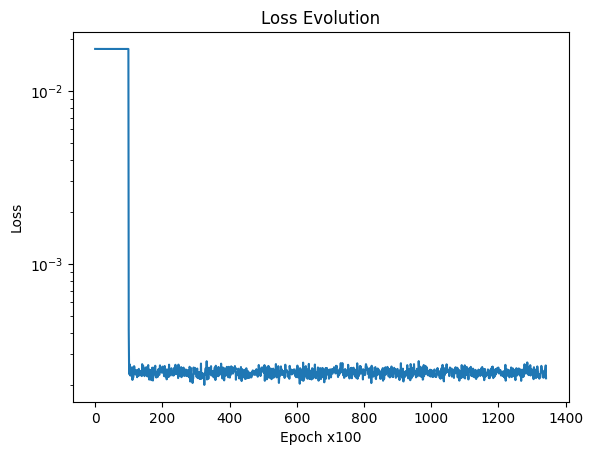

In [193]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

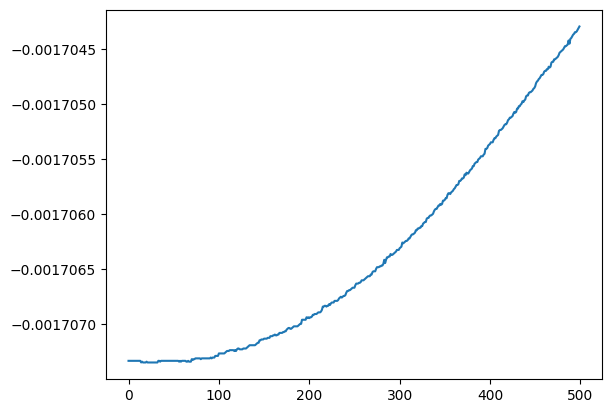

In [198]:
x_flat = jnp.linspace(-1, 1, 500)
outputs = jax.vmap(model)(x_flat)

plt.plot(outputs)
#plt.plot(res_05)
#plt.ylim([0.1, 0.8])
plt.show()

In [19]:
class Greenshield():
    def __init__(self, params):
        self.params=params
        self.v_max = self.params[0]
        self.p_max = self.params[1]
    
    def flux(self, density):
        return self.v_max * (1 - (density/self.p_max))
    
    def __str__(self):
        return "Greenshield"

In [219]:
def linspace_repeat(start, stop, num, repeats):
    # Generate linspace values
    linspace_values = jnp.linspace(start, stop, num)
    # Repeat each value 'repeats' times
    repeated_values = jnp.repeat(linspace_values, repeats)
    return repeated_values

In [294]:
steps = 20
repeat = 15

x_key = jax.random.PRNGKey(7)
#x = jax.random.uniform(x_key, (size,))*L
x = linspace_repeat(0, L, steps, repeat)

In [295]:
len(x)

300

In [296]:
y = jax.vmap(model)(x)

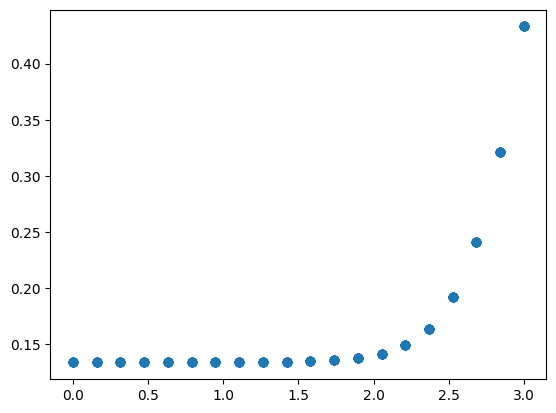

In [297]:
plt.scatter(x,y)
plt.show()

In [298]:
func = Greenshield([v_max, p_max])

In [299]:
means = func.flux(y)

In [300]:
means.shape

(300,)

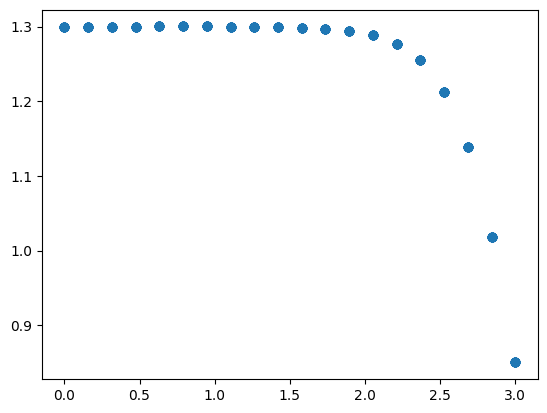

In [301]:
plt.scatter(x, means)
#
plt.show()

In [302]:
key = jax.random.PRNGKey(12)
dt = 0.1
noise = jax.random.normal(key, shape=(repeat*steps,))*jnp.sqrt(sigma2*dt)

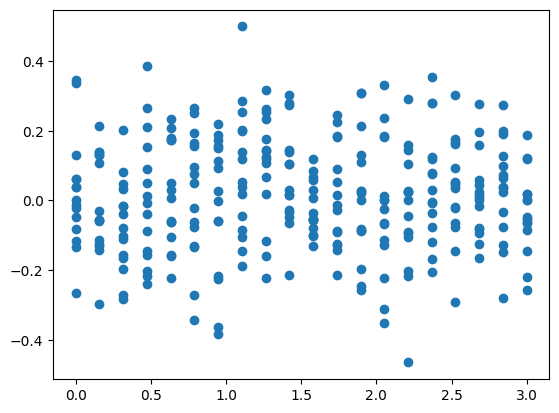

In [303]:
plt.scatter(x, noise)
plt.show()

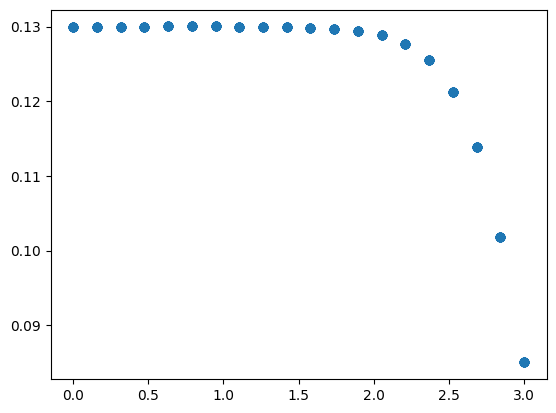

In [304]:
plt.scatter(x, means*dt)
#plt.ylim([0.5, 0.8])
plt.show()

In [305]:
key = jax.random.PRNGKey(7)
samples = means*dt + noise

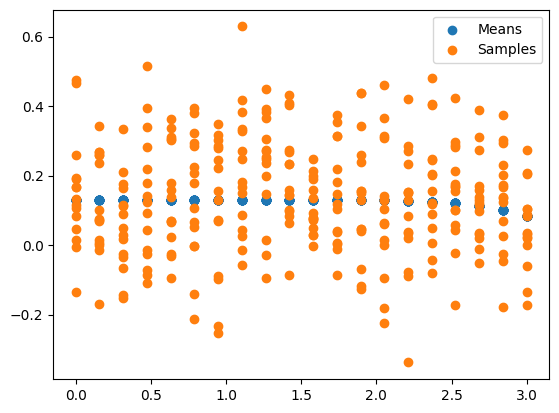

In [310]:
plt.scatter(x, means*dt, label='Means')
plt.scatter(x, samples, label='Samples')
#plt.scatter(x, noise, label='Noise')
plt.legend()
plt.show()

In [307]:
with open('x_values.npy', 'wb') as f:
    jnp.save(f, x)

In [308]:
with open('sample_values.npy', 'wb') as f:
    jnp.save(f, samples)

In [309]:
with open('means_values.npy', 'wb') as f:
    jnp.save(f, means*dt)

In [245]:
def extract_weights(model):
    weights = []
    for layer in model.layers:
        weights.append(layer.weight.flatten())
        weights.append(layer.bias.flatten())
    return jnp.concatenate(weights)

In [604]:
w_30 = extract_weights(model)

In [248]:
w_15

Array([-0.23663503,  0.04501038,  0.06011234, -1.7434026 ,  1.1453986 ,
        0.4586092 , -0.09523066, -0.0706974 ,  0.22513817,  0.34260044,
        0.00224442, -0.1193314 ,  0.32790342, -0.43162364,  0.14924867,
       -0.70392615, -0.34025213, -0.0547112 ,  0.08854806,  0.1537855 ,
       -0.06872196, -0.60784125, -0.07926098, -0.65052944,  0.3703186 ,
        0.30363142,  0.6894678 ,  0.04675508,  0.349182  ,  0.14411794,
        0.20980333,  0.8380722 , -0.16536091,  0.03240588], dtype=float32)

In [260]:
w_14

Array([-0.01886487, -0.07763623,  0.0682521 , -1.7322133 ,  1.0825634 ,
        0.5454949 , -0.19751894, -0.07382164,  0.31850702,  0.3293328 ,
       -0.12012529,  0.00620866,  0.1894416 , -0.37295517,  0.19061677,
       -0.6517513 , -0.3476283 ,  0.02140443,  0.04122147,  0.13946979,
       -0.154498  , -0.6596227 , -0.1045586 , -0.7436725 ,  0.39917564,
        0.29935205,  0.7526574 ,  0.05942841,  0.37012112,  0.14889094,
        0.27526522,  0.8802568 , -0.24536434,  0.04323521], dtype=float32)

In [272]:
w_10

Array([-0.70581836, -0.21816447,  0.3103594 , -1.3245158 ,  2.0237687 ,
        0.46241713, -1.0231875 ,  0.12140357,  0.47472465,  0.37860808,
       -1.0041484 ,  1.2586603 , -0.32091677, -0.88251716,  0.4564254 ,
       -0.40795338, -0.31685358, -0.16866374, -0.7281786 ,  0.4279303 ,
       -0.03598702, -1.2421377 ,  0.18442698, -0.39214852,  1.0480672 ,
        0.51951706,  2.0311275 ,  0.24034218,  0.576844  ,  0.12072784,
        2.1704063 ,  1.200612  , -1.1574608 ,  0.1300677 ], dtype=float32)

In [291]:
w_20

Array([ 0.85398746,  0.9974071 ,  0.27375442, -2.4042788 , -0.8012333 ,
        0.615171  , -0.37599793, -0.02460134,  0.5619073 ,  0.2229701 ,
       -0.469443  , -0.37401405,  0.21095343, -0.6522791 ,  0.15386069,
       -0.5644705 ,  0.12027179,  0.11973571,  0.18166065, -0.0159424 ,
       -0.13871405, -0.4915764 , -0.2519924 , -0.9823736 ,  0.7459361 ,
        0.18463553,  1.2154721 ,  0.09624726,  0.39142776,  0.21628962,
        0.33447614,  0.96043116,  0.5631767 ,  0.06246009], dtype=float32)

In [345]:
jnp.corrcoef(jnp.stack((w_10, w_14, w_15, w_20)))

Array([[1.        , 0.7528726 , 0.712824  , 0.39555433],
       [0.7528726 , 0.9999999 , 0.98825145, 0.6991485 ],
       [0.712824  , 0.98825145, 1.        , 0.6722142 ],
       [0.39555433, 0.6991485 , 0.6722142 , 1.        ]], dtype=float32)

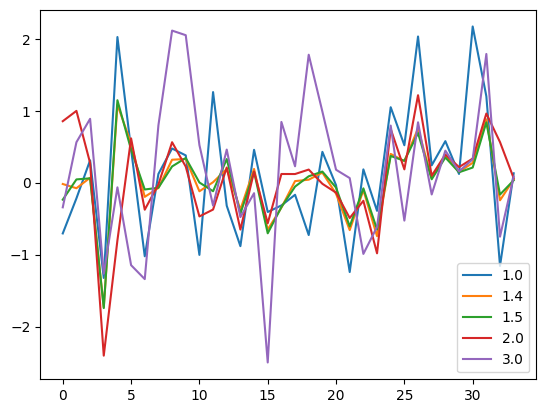

In [605]:
plt.plot(w_10, label = '1.0')
plt.plot(w_14, label = '1.4')
plt.plot(w_15, label = '1.5')
plt.plot(w_20, label = '2.0')
plt.plot(w_30, label = '3.0')

plt.legend()
plt.show()

In [265]:
def get_weights(model):
    weights = []
    for layer in model.layers:
        weights.append(layer.weight)
    return weights

In [274]:
trained_weights = get_weights(model)
trained_weights

[Array([[-0.5893153 ],
        [-0.65002257]], dtype=float32),
 Array([[ 2.015867  , -3.0652652 ],
        [ 0.94027215, -1.4652383 ]], dtype=float32),
 Array([[-0.3792793 , -1.5083473 ],
        [-0.3230125 ,  0.47585058]], dtype=float32),
 Array([[0.19262725, 0.6272823 ]], dtype=float32)]

In [273]:
trained_weights_20

[Array([[-0.10842768],
        [-0.24311486]], dtype=float32),
 Array([[ 0.7329991 , -0.50644493],
        [ 1.5691452 , -1.0729849 ]], dtype=float32),
 Array([[-0.7466465 , -0.15541852],
        [-0.6989294 ,  0.32326072]], dtype=float32),
 Array([[0.2821968, 0.8004125]], dtype=float32)]

Ideia de distancia: Mede a distancia entre cada uma das matrizes. Coloque esses valores num vetor e meça a distancia euclidiana desse vetor. Pode colocar um peso para cada posição do vetor, sendo quando mais para a entrada, maior o peso, já que a parada se propaga, mas não tenho certeza se é necessário.

In [68]:
import jax.numpy as jnp

def sum_squared_differences(list1, list2):
    """
    Calculate the sum of squared differences element-wise for two lists of jnp.arrays.

    Parameters:
    list1 (list of jnp.array): First list of arrays.
    list2 (list of jnp.array): Second list of arrays.

    Returns:
    float: Sum of squared differences.
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length")
    
    total_sum = 0.0
    for arr1, arr2 in zip(list1, list2):
        total_sum += jnp.sum((arr1 - arr2) ** 2)
    
    return total_sum
